In [ ]:
!pip install pythainlp

     |████████████████████████████████| 11.1MB 4.4MB/s 
     |████████████████████████████████| 1.4MB 39.5MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434674 sha256=6651d0e1f442cd0160647168ee90f0990bd99f16f72deb5e1cf1008d943837de
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
  Found existing installation: requests 2.21.0
    Uninstalling requests-2.21.0:
      Successfully uninstalled requests-2.21.0


In [ ]:
!git clone https://github.com/wannaphong/thai-ner

Cloning into 'thai-ner'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 379 (delta 7), reused 0 (delta 0), pack-reused 356
Receiving objects: 100% (379/379), 130.96 MiB | 24.03 MiB/s, done.
Resolving deltas: 100% (169/169), done.
Checking out files: 100% (228/228), done.


In [ ]:
import re
from pythainlp import word_tokenize
from glob import glob 

train_filenames = glob('thai_ner_train/*.txt')
feature_sequence_list = []
label_sequence_list = []
for filename in train_filenames:
    with open(filename) as f:
        for line in re.split(r'\n\n+', f.read()):
            line = line.strip()
            phrases = re.split(r'<(pers|org|place)Name.+?>(.+?)</\s?\1Name>', line)
            phrases = [re.sub(r'<.+?>', '', x) for x in phrases]

            X, Y = [], []

            index = 0 
            while index < len(phrases):
                if phrases[index] in ['pers', 'place', 'org']:
                   ne_type = phrases[index]
                   tokens = word_tokenize(phrases[index+1], engine = 'newmm')
                   X += tokens
                   Y += [f'B-{ne_type}'] + (len(tokens) -1) * [f'I-{ne_type}']
                   index += 2
                else:
                   tokens = word_tokenize(phrases[index], engine = 'newmm')
                   X += tokens
                   Y += ['O'] * (len(tokens))
                   index += 1
            feature_sequence_list.append(X)
            label_sequence_list.append(Y)
            print(X)
            print(Y)
            print(len(X), len(Y), '\n')

In [ ]:
feature_sequence_list = [x for x in feature_sequence_list if x != []]
label_sequence_list = [x for x in label_sequence_list if x != []]

In [ ]:
c = 0
word_ner=[]
for x in feature_sequence_list:
    if c <= len(label_sequence_list) - 1:       
        word_ner.append((feature_sequence_list[c],label_sequence_list[c]))
        c += 1

In [ ]:
len(word_ner)

6722

In [ ]:
word_ner[574][1]

['B-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL',
 'I-URL']

Load data

In [ ]:

import dill
with open('thai-ner/bilstm-crf-model/0.44/datatrain.data', 'rb') as file:
 datatofile = dill.load(file)

In [ ]:

datatofile[1]

[('สงสัย', 'NCMN', 'O'),
 ('ติด', 'VACT', 'O'),
 ('หวัด', 'NCMN', 'O'),
 ('นก', 'DDAC', 'O'),
 (' ', 'NCMN', 'O'),
 ('อีก', 'DDBQ', 'O'),
 ('คน', 'NCMN', 'O'),
 ('ยัง', 'XVBM', 'O'),
 ('น่า', 'VSTA', 'O'),
 ('ห่วง', 'NCMN', 'O')]

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
from sklearn.model_selection import cross_validate,train_test_split
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

print(torch.__version__)

1.4.0


In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#torch.backends.cudnn.benchmark=torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.long
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [ ]:
word_ner=[]
for i in datatofile:
    t1=[]
    t2=[]
    for j in i:
        t1.append(j[0])
        t2.append(j[2])
    word_ner.append((t1,t2))

In [ ]:

tagged_sents=word_ner

In [ ]:
len(tagged_sents)

6722

In [ ]:
tagged_sents[57][1]

['B-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'O',
 'O',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'I-ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORGANIZATION',
 'O',
 'O',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-LOCATION',
 'I-LOCATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'O',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'I-ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PERCENT',
 'I-PERCENT',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
cc = 0
new=[]
while cc <= len(word_ner) - 1:
   
  for n, i in enumerate(tagged_sents[cc][1]):
    
    if i == 'B-org':
      tagged_sents[cc][n] = 'B-ORGANIZATION'
    new.append(tagged_sents[cc])
    cc += 1

IndexError: ignored

In [ ]:
new6[577]

['B-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'I-ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-LOCATION',
 'O',
 'O',
 'O',
 'B-LOCATION',
 'I-LOCATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 

In [ ]:
c = 0
word_ner=[]
while c <= len(tagged_sents) - 1:
           
    word_ner.append((tagged_sents[c][0],new6[c]))
    c += 1

In [ ]:
word_ner[0]

(['http',
  '://',
  'www',
  '.',
  'bangkokhealth',
  '.',
  'com',
  '/',
  'healthnews',
  '_',
  'htdoc',
  '/',
  'healthnews',
  ' ',
  '_',
  ' ',
  'detail',
  '.',
  'asp',
  '?',
  'Number',
  '=',
  '10506'],
 ['B-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL'])

In [ ]:
cc = 0

while cc <= 0:
  [file.replace('B-org', 'B-ORGANIZATION') for file in tagged_sents[cc][1]]
  print(file)
  [file.replace('I-org', 'I-ORGANIZATION') for file in tagged_sents[cc][1]]
  [file.replace('B-pers', 'B-PERSON') for file in tagged_sents[cc][1]]
  [file.replace('I-pers', 'I-PERSON') for file in tagged_sents[cc][1]]
  [file.replace('B-place', 'B-LOCATION') for file in tagged_sents[cc][1]]
  [file.replace('I-place', 'I-LOCATION') for file in tagged_sents[cc][1]]
  cc += 1

<_io.BufferedReader name='thai-ner/bilstm-crf-model/0.44/datatrain.data'>


In [ ]:
new[0]

<_io.BufferedReader name='thai-ner/bilstm-crf-model/0.44/datatrain.data'>

In [ ]:

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else to_ix["UNK"] for w in seq]
    return torch.tensor(idxs, dtype=LongTensor, device=device)

def prepare_sequence_no_tensor(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else to_ix["UNK"] for w in seq]
    return idxs



# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [ ]:
prepare_sequence_no_tensor(['B-PERSON','I-PERSON'], pos_to_ix)

[10, 23]

In [ ]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size, device=device))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2,device=device),
                torch.randn(2, 1, self.hidden_dim // 2,device=device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000., device=device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1,device=device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=LongTensor, device=device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000., device=device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 64
HIDDEN_DIM = 128

In [ ]:

#split data into train set and test set
train_size = int(len(tagged_sents) * 0.8)
train_sents = tagged_sents[:train_size]
test_sents = tagged_sents[train_size:]
#list of tupule of list of word/pos# 

In [ ]:

train_sents[0]

(['http',
  '://',
  'www',
  '.',
  'bangkokhealth',
  '.',
  'com',
  '/',
  'healthnews',
  '_',
  'htdoc',
  '/',
  'healthnews',
  ' ',
  '_',
  ' ',
  'detail',
  '.',
  'asp',
  '?',
  'Number',
  '=',
  '10506'],
 ['B-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL'])

Preparing data

In [ ]:
train_sents

[(['http',
   '://',
   'www',
   '.',
   'bangkokhealth',
   '.',
   'com',
   '/',
   'healthnews',
   '_',
   'htdoc',
   '/',
   'healthnews',
   ' ',
   '_',
   ' ',
   'detail',
   '.',
   'asp',
   '?',
   'Number',
   '=',
   '10506'],
  ['B-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL',
   'I-URL']),
 (['สงสัย', 'ติด', 'หวัด', 'นก', ' ', 'อีก', 'คน', 'ยัง', 'น่า', 'ห่วง'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 (['ตามที่',
   'นาง',
   'ประนอม',
   ' ',
   'ทอง',
   'จันทร์',
   ' ',
   'กับ',
   ' ',
   'ด.ช.',
   'กิตติ',
   'พง',
   'ษ์',
   ' ',
   'แหลม',
   'ผักแว่น',
   ' ',
   'และ',
   ' ',
   'ด.ญ.',
   'กาญจนา',
   ' ',
   'กรอง',
   'แก้ว',
   ' ',
   'ป่วย',
   'สงสัย',
   'ติดเชื้อ',
   'ไข้',
   'ขณะนี้',
   'ยัง',
   'ไม่',
   'ดีขึ้น'],

In [ ]:
word_list=[]
pos_list=[]

for sent,tags in train_sents:
    for word in sent:
        word_list.append(word)
    for tag in tags:
        pos_list.append(tag)

#Word to Index
word_list.append("UNK") #Special Token for unknown words
pos_list.append(START_TAG)
pos_list.append(STOP_TAG)
all_words = sorted(set(word_list))
all_pos = sorted(set(pos_list))
#del word_list, pos_list
word_to_ix = dict((c, i) for i, c in enumerate(all_words)) #convert word to index 
pos_to_ix = dict((c, i) for i, c in enumerate(all_pos)) #convert pos to index

^
ทำ word และ tag ให้เป็นตัวเลข

In [ ]:
print(pos_to_ix) # NER tags

{'<START>': 0, '<STOP>': 1, 'B-DATE': 2, 'B-EMAIL': 3, 'B-LAW': 4, 'B-LEN': 5, 'B-LOCATION': 6, 'B-MONEY': 7, 'B-ORGANIZATION': 8, 'B-PERCENT': 9, 'B-PERSON': 10, 'B-PHONE': 11, 'B-TIME': 12, 'B-URL': 13, 'B-ZIP': 14, 'I-DATE': 15, 'I-EMAIL': 16, 'I-LAW': 17, 'I-LEN': 18, 'I-LOCATION': 19, 'I-MONEY': 20, 'I-ORGANIZATION': 21, 'I-PERCENT': 22, 'I-PERSON': 23, 'I-PHONE': 24, 'I-TIME': 25, 'I-URL': 26, 'O': 27}


In [ ]:
ix_to_word = dict((v,k) for k,v in word_to_ix.items()) #convert index to word
ix_to_pos = dict((v,k) for k,v in pos_to_ix.items())  #convert index to word

^
ทำ dic ที่เลขกลายเป็น key แทน

Preparing data for Pytorch

In [ ]:
model = BiLSTM_CRF(len(word_to_ix), pos_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
model.to(device)

BiLSTM_CRF(
  (word_embeds): Embedding(12739, 64)
  (lstm): LSTM(64, 64, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=28, bias=True)
)

In [ ]:
tag_to_ix=pos_to_ix
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:

train_sents[0]

(['พระ',
  'ร่วม',
  'ม็อบ',
  'ต้าน',
  "'",
  'เบียร์',
  'ช้าง',
  "'",
  'เข้า',
  'ตลท.',
  '\n',
  ' ',
  '\n',
  ' ',
  '\n',
  ' ',
  'ที่',
  'ตลาดหลักทรัพย์',
  'แห่ง',
  'ประเทศ',
  'ไทย',
  ' ',
  '\n',
  '(',
  'ตลท.',
  ')',
  ' ',
  'เมื่อ',
  'เวลา',
  ' ',
  '09.30',
  ' ',
  'น.',
  ' ',
  'วันที่',
  ' ',
  '20',
  ' ',
  'พ.ย.',
  ' ',
  'กลุ่ม',
  'เครือข่าย',
  'ภาค',
  'ประชาชน',
  'ที่',
  'ได้รับ',
  'ผลกระทบ',
  'จาก',
  'เครื่องดื่ม',
  'แอลกอฮอล์',
  ' ',
  'รวม',
  ' ',
  '384',
  ' ',
  'องค์กร',
  ' ',
  'มี',
  'ทั้ง',
  ' ',
  'ฆราวาส',
  ' ',
  'และ',
  'พระสงฆ์',
  ' ',
  'นับ',
  ' ',
  '10,000',
  ' ',
  'คน',
  ' ',
  'รวมตัวกัน',
  'ไป',
  'ชุมนุม',
  'ที่',
  'หน้า',
  'อาคาร',
  ' ',
  '\n',
  'ตลท.',
  ' ',
  'เพื่อ',
  'ต่อต้าน',
  'คัดค้าน',
  'การนำ',
  ' ',
  '\n',
  'บริษัท',
  ' ',
  'ไทย',
  'เบฟเวอเรจ',
  ' ',
  'จำกัด',
  ' ',
  '(',
  'มหาชน',
  ')',
  ' ',
  'ผู้ผลิต',
  ' ',
  '“',
  'เบียร์',
  'ช้าง',
  '”',
  ' ',
  'เข้า',
  'จด

In [ ]:
with torch.no_grad():
    precheck_sent = prepare_sequence(train_sents[0][0], word_to_ix) #เอา input มาทำเป็นตัวเลข#
    precheck_tags = torch.tensor([tag_to_ix[t] for t in train_sents[0][1]], dtype=LongTensor, device=device) #เอา tag ของ input มาทำเป็นตัวเลข#
    print(precheck_sent)
    print(model(precheck_sent))

tensor([1671, 1072, 1767,   59, 1630,   59, 1646,   70, 1668, 1620, 1670,   70,
        1668,    0, 1620,    0, 1653,   59, 1628, 1076, 1417, 1073,  260])
(tensor(45.6933), [2, 22, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 26, 16, 27, 13])


In [ ]:
def train(sentence, tags,train=True):
    if train:
        model.train(True)
    else:
        model.eval()
    model.zero_grad()
    sentence_in = prepare_sequence(sentence, word_to_ix)
    targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=LongTensor, device=device)
    loss = model.neg_log_likelihood(sentence_in, targets)
    if train:
        loss.backward()#backprop
        optimizer.step()#update parameters
    return loss.item()

In [ ]:
import time
import math

n_iters = 10
print_every = 1

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
train_losses=[]
val_losses=[]
for iter in range(1, n_iters + 1):#Epoch
    loader = tqdm(train_sents, total=len(train_sents))
    for sentence, pos_tags in loader: #Sentence
        loss = train(sentence, pos_tags) #fwd
    loader = tqdm(train_sents, total=len(train_sents))
    for sentence, pos_tags in loader: #Sentence
        val_loss = train(sentence, pos_tags,train=False) #fwd
    # Print iter number,time, loss
    if iter % print_every == 0:
        print('ep %d %d%% (%s) loss %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))
        print('val loss %.4f ' % (val_loss))
        train_losses.append(loss)
        val_losses.append(val_loss)
        torch.save(model.state_dict(), "ner_3.pt.ep"+str(iter))


  0%|          | 1/5377 [00:01<2:40:45,  1.79s/it]

IndexError: ignored

In [ ]:
#load model#



model.load_state_dict(torch.load('ner-2.pt.ep20'))
model.to(device)


BiLSTM_CRF(
  (word_embeds): Embedding(12739, 64)
  (lstm): LSTM(64, 64, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=28, bias=True)
)

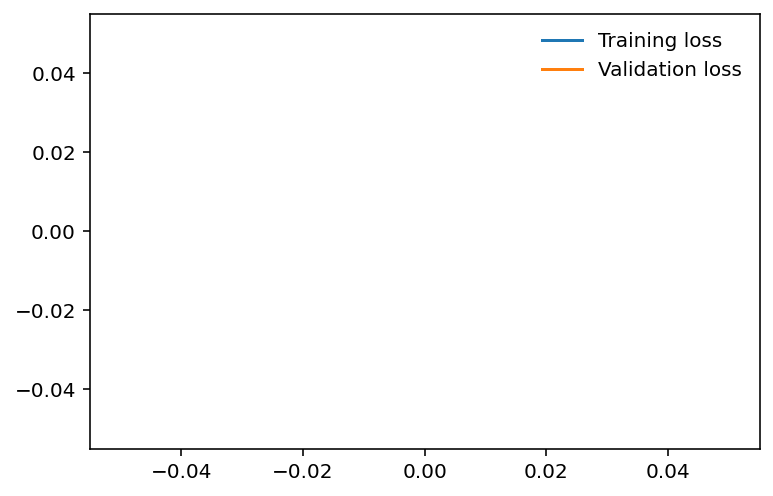

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
with torch.no_grad():
    precheck_sent = prepare_sequence(train_sents[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in train_sents[0][1]], dtype=LongTensor, device=device)
    print(precheck_sent)
    print(model(precheck_sent))

tensor([1671, 1072, 1767,   59, 1630,   59, 1646,   70, 1668, 1620, 1670,   70,
        1668,    0, 1620,    0, 1653,   59, 1628, 1076, 1417, 1073,  260])
(tensor(288.3056), [13, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26])


In [ ]:
def predict(input_sent):
    y_pred=[]
    temp=[]
    with torch.no_grad():
        precheck_sent = prepare_sequence(input_sent, word_to_ix)
        output=model(precheck_sent)[1]
        y_pred=[ix_to_pos[i] for i in output]
    
    return y_pred

In [ ]:
def predict_array(input_sent):
    y_pred=[]
    temp=[]
    with torch.no_grad():
        precheck_sent = prepare_sequence(input_sent, word_to_ix)
        output=model(precheck_sent)[1]
        
    
    return output

In [ ]:
print(test_sents[2][0])
print(predict(test_sents[2][0]))
print(test_sents[2][1])

['“', ' ', 'ไม่ใช่', 'เขา', 'ไม่รู้', 'หลายอย่าง', 'ที่', 'ทำ', 'มัน', 'เกินไป', ' ', 'แต่', 'สังคม', 'ไทย', 'เต็มไปด้วย', 'คน', 'ที่', 'ขี้ขลาด', 'ตาขาว', 'และ', 'คน', 'เหล่านั้น', 'สมควร', 'ได้รับ', 'การ', 'ดูถูก', 'ดูหมิ่น', ' ', 'คน', 'เหล่านั้น', 'ได้ยิน', 'แล้ว', 'ว่า', 'ตำรวจ', ' ', '6', ' ', 'คน', 'ถูกจับ', 'หลังจาก', 'ไม่', 'กี่', 'วันหลัง', 'วันที่', ' ', '24', ' ', 'กันยายน', ' ', '2519', ' ', 'แล้ว', 'ยัง', 'เฉย', 'อยู่', 'อีก', ' ', 'คนขี้ขลาด', 'เต็มบ้านเต็มเมือง', ' ', 'นี้', 'เรา', 'ไทยแลนด์', ' ', '4.0', ' ', 'ไทยแลนด์', 'ของ', 'คนขี้ขลาด', 'ต้อง', 'เป็น', 'นายก', 'ของ', 'ประชาชน', 'ตาดำ', ' ', 'ๆ', ' ', 'จำนวน', 'มหาศาล', ' ', 'เห็น', 'ความอยุติธรรม', 'แล้ว', 'ไม่', 'จัดการ', 'ให้', 'เรียบร้อย', ' ', 'อย่างนี้', 'ไม่', 'เรียก', 'ว่า', 'ขี้ขลาด', 'ได้', 'อย่างไร', '”', ' ', 'ศาสตราจารย์', 'กิตติคุณ', 'ธง', 'ชัย', 'กล่าว']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', '

In [ ]:
predict(["ผม","ชื่อ","นาย","บุญ","มาก"," ","ทอง","ดี","วัน","นี้","วัน","จันทร์"])

['O',
 'O',
 'B-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'O',
 'O',
 'O']

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from itertools import chain

def bio_classification_report(y_true, y_pred):
    """
    Classification report for a list of BIO-encoded sequences.
    It computes token-level metrics and discards "O" labels.
    
    Note that it requires scikit-learn 0.15+ (or a version from github master)
    to calculate averages properly!
    """
    lb = LabelEncoder()
    flattened_y_true = list(chain.from_iterable(y_true))
    flattened_y_pred = list(chain.from_iterable(y_pred))
    y_true_combined = lb.fit_transform(flattened_y_true)
    y_pred_combined = lb.transform(flattened_y_pred)

    tagset = set(lb.classes_) - {'O','I-EMAIL','B-EMAIL','B-ZIP','B-DATE','I-DATE','B-LAW','I-LAW','B-LEN','I-LEN','B-MONEY','I-MONEY','B-PERCENT','I-PERCENT','B-TIME','I-TIME','B-PHONE','I-PHONE','B-URL','I-URL'} #{'O', 'ENDPAD'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    accuracy = np.mean([x==y for x, y in zip(flattened_y_true, flattened_y_pred) if x != 'ENDPAD'])
    print(np.round(accuracy, 2))

    print (classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset)
    ) 

In [ ]:
test_sents[0][0]

['ศาสตราจารย์',
 'กิตติคุณ',
 'ธงชัย',
 ' ',
 'วินิจ',
 'จะ',
 'กู',
 'ล',
 ' ',
 'จาก',
 'สถาบัน',
 ' ',
 'IDE-Jetro',
 ' ',
 'ประเทศญี่ปุ่น',
 'กล่าวถึง',
 'ระบบ',
 'โซ',
 'ตัส',
 'ใน',
 'สังคม',
 'ไทย',
 'ว่า',
 ' ',
 'ระบบ',
 'โซ',
 'ตัส',
 'ที่',
 'ใหญ่',
 'ที่สุด',
 'ไม่ได้',
 'อยู่',
 'ใน',
 'มหาวิทยาลัย',
 ' ',
 'แต่',
 'เป็นระบบ',
 'ของ',
 'ทหาร',
 ' ',
 'ซึ่ง',
 'จริง',
 ' ',
 'ๆ',
 ' ',
 'แล้ว',
 'ยัง',
 'มีระบบ',
 'โซ',
 'ตัส',
 'ที่',
 'ใหญ่',
 'กว่า',
 'นั้น',
 'ก็',
 'คือ',
 'ระบบ',
 'ราชการ',
 'แต่',
 'อำนาจ',
 'ไม่',
 'แรง',
 'เท่า']

In [ ]:
prepare_sequence()

In [ ]:
len(test_sents)

1345

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
target_names = ['B-PERSON', 'I-PERSON', 'B-ORGANIZATION', 'I-ORGANIZATION', 'B-LOCATION', 'I-LOCATION']
predict_answer_list = []
real_answer_list = []
count = 0
for test_id, test in enumerate(test_sents):
    if count <= len(test_sents) - 1:
        if test_sents[count][0] != []:
            
            predict_answer_list.append(predict(test_sents[count][0])) #list of list of predict tag#
            real_answer_list.append(test_sents[count][1])
                
            count += 1
            #real_answer_list.append(np.array([pos_to_ix[uu] if uu in pos_to_ix for uu in test_sents[count][1]])) #list of list of ans tag#
            
print(predict_answer_list)
print(real_answer_list)
print(bio_classification_report(real_answer_list, predict_answer_list))

[['B-PERSON', 'I-PERSON', 'I-PERSON', 'I-PERSON', 'I-PERSON', 'I-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION',

In [ ]:
def predict_list(input_sent): 
    y_pred=[]
    temp=[]
    with torch.no_grad():
        for ii in input_sent:
            precheck_sent = prepare_sequence(ii, word_to_ix)
            output=model(precheck_sent)[1]
            y_pred.append([ix_to_pos[i] for i in output])
    
    return y_pred

In [ ]:
import re

with open('thai_ner_train_no_answers/corpus004-utf8.txt', encoding='utf8') as test:
    testlist = []
    for line in re.split(r'\n\n+', test.read()):
        line = line.strip()
        phrases = word_tokenize(line, engine="newmm")
        if phrases != []:
            testlist.append(phrases)
       

In [ ]:
predict(['นาย', 'กิตติ', 'ศักดิ์', ' ', 'กีรติ', 'ยะ', 'อังกูร', ' ', 'ผู้เชี่ยวชาญ', 'ด้าน', 'จุลินทรีย์', ' ', 'กรมวิชาการเกษตร', '  ', 'เผย', 'ถึง'])

In [ ]:
print(testlist)

predict_list(testlist)

[['เวที', 'อาเซียน', 'ถก', 'ไม่', 'คืบ', ' ', 'กรอบ', 'ตรวจสอบ', 'GMO', ' ', 'ไทย', 'ฟุ้ง', 'มีระบบ', 'พร้อม'], ['นาย', 'กิตติ', 'ศักดิ์', ' ', 'กีรติ', 'ยะ', 'อังกูร', ' ', 'ผู้เชี่ยวชาญ', 'ด้าน', 'จุลินทรีย์', ' ', 'กรมวิชาการเกษตร', '  ', 'เผย', 'ถึง', 'ความคืบหน้า', 'ของ', 'ความร่วมมือ', 'การ', 'ตรวจ', 'วิเคราะห์', 'อาหาร', 'จีเอ็มโอ', 'ของ', 'ประเทศสมาชิก', 'อาเซียน', ' ', 'ว่า', '  ', 'ยัง', 'ไม่', 'มี', 'ความคืบหน้า', 'ใดๆ', ' ', 'ภาย', 'หลังจาก', 'การประชุม', 'ใน', 'รอบ', 'ที่แล้ว', 'ซึ่ง', 'มี', 'ประเทศ', 'เวียดนาม', ' ', 'แต่', 'ขณะนี้', 'ยัง', 'ไม่', 'ได้รับ', 'การ', 'ติดต่อ', 'ใด', ' ', 'ๆ', '  ', 'จาก', 'ประเทศ', 'ดังกล่าว', ' ', 'อย่างไรก็ดี', ' ', 'คง', 'ต้อง', 'จัด', 'ให้', 'มี', 'การประชุม', 'อีกครั้ง', 'ภายใน', 'ปี', ' ', '2007', ' ', 'แน่นอน'], ['ทั้งนี้', ' ', 'ใน', 'การประชุม', 'ครั้ง', 'ที่แล้ว', ' ', 'ที่ประชุม', 'ได้', 'มี', 'การหารือ', 'ใน', 'เรื่อง', 'ของ', 'การ', 'สร้าง', 'เครือข่าย', 'การ', 'ตรวจ', 'วิเคราะห์', 'อาหาร', 'ที่', 'เป็น', 'จีเอ็มโอ', ' ', 'โดย',

[['O',
  'B-ORGANIZATION',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['B-PERSON',
  'I-PERSON',
  'I-PERSON',
  'I-PERSON',
  'I-PERSON',
  'I-PERSON',
  'I-PERSON',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ORGANIZATION',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ORGANIZATION',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-LOCATION',
  'I-LOCATION',
  'O',
  'O',
  'B-TIME',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-DATE',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',


In [ ]:
def extract_word2(WordAndTag): #input = tuple >> (list of word, list of tag)
    ans = {}

    #adding filename dictionary to the answer
    for file_id, filename in enumerate(train_filenames):
        ans[filename[26:]] = {"place":[], "org":[], "pers":[] }

        #for loop list of tag in the current doc
        for tag_id, tag in enumerate(WordAndTag[1][file_id]):
            name = []
            #B and I checker
            if tag == 'B-PERSON' or tag == 'B-ORGANIZATION' or tag == 'B-LOCATION':
                name.append(WordAndTag[0][file_id][tag_id])
                counter = 1
                try:
                    while 'I' in WordAndTag[1][file_id][tag_id + counter]:
                        name.append(WordAndTag[0][file_id][tag_id + counter])
                        counter += 1
                    else:
                        full_name = ''.join(name)
                        category = ''
                        if tag == 'B-PERSON':
                            category = 'pers'
                        elif tag == 'B-ORGANIZATION':
                            category = 'org'
                        elif tag == 'B-LOCATION':
                            category = 'place'
                        if full_name not in ans[filename[26:]][category]:
                            ans[filename[26:]][category].append(full_name)
                except:
                    full_name = ''.join(name)
                    category = ''
                    if tag == 'B-PERSON':
                        category = 'pers'
                    elif tag == 'B-ORGANIZATION':
                        category = 'org'
                    elif tag == 'B-LOCATION':
                        category = 'place'
                    if full_name not in ans[filename[26:]][category]:
                        ans[filename[26:]][category].append(full_name)
    return ans

ทำ custom dic

In [ ]:
from pythainlp.corpus.common import thai_words
from pythainlp.tokenize import dict_trie
custom_dict_japanese_name = set(thai_words())
custom_dict_japanese_name.add('กระทรวงการพัฒนาสังคมและความมั่นคงของมนุษย์')
custom_dict_japanese_name.add('ติดลบ')
custom_dict_japanese_name.add('ลดตัว')
custom_dict_japanese_name.add('หดตัว')
custom_dict_japanese_name.add('เดือนก่อน')
custom_dict_japanese_name.add('เทสโก้')
custom_dict_japanese_name.add('ประธานกรรมการ')
custom_dict_japanese_name.add('กระทรวงการพัฒนาสังคมและความมั่นคงของมนุษย์')
custom_dict_japanese_name.add('ค้าปลีก')
custom_dict_japanese_name.add('สกอ.')
custom_dict_japanese_name.add('กกอ.')
custom_dict_japanese_name.add('คณะกรรมการการอุดมศึกษา')
custom_dict_japanese_name.add('สำนักงานคณะกรรมการการอุดมศึกษา')
custom_dict_japanese_name.add('เกษตรศาสตร์')
custom_dict_japanese_name.add('อักษรศาสตร์')
custom_dict_japanese_name.add('คณะวิทยาศาสตร์')
custom_dict_japanese_name.add('ไอส์สไตน์')
custom_dict_japanese_name.add('ม.เกษตรศาสตร์')
custom_dict_japanese_name.add('รศ.')


trie = dict_trie(dict_source=custom_dict_japanese_name)
#word_tokenize(text, engine="newmm", custom_dict=trie))

In [ ]:
!pip install attacut

     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 481kB 21.2MB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 276kB 21.1MB/s 
     |████████████████████████████████| 747kB 22.0MB/s 
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=b9bd7afe45a3bd120465a5ed342a00e9f5dcf69df618cafd682ad0993f9c69bb
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=d5847b02e48f5c349566f00de5803120b6122a1a71ccd79ee5396ec0d88506b9
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built fire pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import re
from pythainlp import word_tokenize
from glob import glob 

train_filenames = glob('thai_ner_test_set_no_answers/*.txt')


def file_to_xy(train_filenames):
    word_list = []
    tag_list = []
    for filename in train_filenames:
        with open(filename, encoding="utf8") as f:
            rew = []
            kwai_rew = []

            for line in re.split(r'\n\n+', f.read()):
                line = line.replace('\n', '').strip()
                phrases = word_tokenize(line, engine="newmm")
                if phrases != []:
                    for i in phrases:                        
                        rew.append(i)
                    for z in predict(phrases):
                        kwai_rew.append(z)
            word_list.append(rew)
            tag_list.append(kwai_rew)                
    
    return word_list, tag_list
    print(train_filenames)

def extract_word2(WordAndTag,file): #input = tuple >> (list of word, list of tag) file = str of filename after glob
    ans = {}
    
    #adding filename dictionary to the answer
    for file_id, filename in enumerate(train_filenames):
        namey = filename.split('/')[1]
        ans[namey] = {"place":[], "org":[], "pers":[] }
        
        #for loop list of tag in the current doc
        for tag_id, tag in enumerate(WordAndTag[1][file_id]):
            name = []
            #B and I checker
            if tag == 'B-PERSON' or tag == 'B-ORGANIZATION' or tag == 'B-LOCATION':  
                name.append(WordAndTag[0][file_id][tag_id])
                counter = 1
                try:
                    while 'I' in WordAndTag[1][file_id][tag_id + counter]:
                        name.append(WordAndTag[0][file_id][tag_id + counter])
                        counter += 1
                    else:
                        full_name = ''.join(name)
                        category = ''
                        if tag == 'B-PERSON':
                            category = 'pers'
                        elif tag == 'B-ORGANIZATION':
                            category = 'org'
                        elif tag == 'B-LOCATION':
                            category = 'place'
                        if full_name not in ans[namey][category]:
                            ans[namey][category].append(full_name)
                except:
                    full_name = ''.join(name)
                    category = ''
                    if tag == 'B-PERSON':
                        category = 'pers'
                    elif tag == 'B-ORGANIZATION':
                        category = 'org'
                    elif tag == 'B-LOCATION':
                        category = 'place'
                    if full_name not in ans[namey][category]:
                        ans[namey][category].append(full_name)
    return ans



In [ ]:
aaa = file_to_xy(train_filenames)

In [ ]:
aaa

([['แจ้ง',
   'เตือน',
   'นักลงทุน',
   'ระวัง',
   'ใบหุ้น',
   'ปลอม',
   ' ',
   '[',
   '4',
   ' ',
   'ธ.ค.',
   ' ',
   '51',
   ' ',
   '-',
   ' ',
   '04',
   ':',
   '15',
   ']',
   ' ',
   'น.ส.',
   'โสภา',
   'วดี',
   ' ',
   'เลิศ',
   'ม',
   'นัย',
   'ชัย',
   ' ',
   'กรรมการผู้จัดการ',
   ' ',
   '<',
   'orgName',
   ' ',
   'Id',
   '="',
   '0172',
   '-org',
   '1',
   '">',
   'บริษัท',
   'ศูนย์',
   'รับฝาก',
   'หลักทรัพย์',
   ' ',
   '(',
   'ประเทศ',
   'ไทย',
   ')',
   ' ',
   'จำกัด',
   ' ',
   'หรือ',
   ' ',
   'TSD',
   ' ',
   'เปิดเผย',
   'ถึง',
   'กรณี',
   'พบ',
   'ใบหุ้น',
   'ปลอม',
   'ของ',
   'บริษัท',
   'เอส',
   '.',
   'อี',
   '.',
   'ซี',
   '.',
   ' ',
   'ออโต้',
   'เซลส์',
   ' ',
   'แอนด์',
   ' ',
   'เซอร์วิส',
   ' ',
   'จำกัด',
   ' ',
   '(',
   'มหาชน',
   ')',
   ' ',
   'หรือ',
   ' ',
   'SECC',
   ' ',
   'ว่า',
   ' ',
   'เชื่อ',
   'ว่า',
   'จะ',
   'มี',
   'ใบหุ้น',
   'ปลอม',
   'ของ',
   ' ',
   'SECC

In [ ]:
for file in train_filenames:
  print(file)

thai_ner_dev_set_no_answers/corpus0157-utf8.txt
thai_ner_dev_set_no_answers/corpus0159-utf8.txt
thai_ner_dev_set_no_answers/corpus0150-utf8.txt
thai_ner_dev_set_no_answers/corpus0152-utf8.txt
thai_ner_dev_set_no_answers/corpus0156-utf8.txt
thai_ner_dev_set_no_answers/corpus0158-utf8.txt
thai_ner_dev_set_no_answers/corpus0154-utf8.txt
thai_ner_dev_set_no_answers/corpus0153-utf8.txt
thai_ner_dev_set_no_answers/corpus0151-utf8.txt
thai_ner_dev_set_no_answers/corpus0155-utf8.txt


In [ ]:
bbb = extract_word2(aaa,train_filenames)

In [ ]:
bbb

{'corpus0160-utf8.txt': {'org': ['คมนาคม',
   'กระทรวงคมนาคม',
   'ขสมก.',
   '(รถ',
   'บขส.',
   'รถร่วมบขส.',
   'บริษัท ปตท.จำกัด (มหาชน)   ',
   'ปตท.',
   'กระทรวงพลังงาน',
   'คณะกรรมการนโยบายพลังงาน',
   'กบง.'],
  'pers': ['นายชัยศักดิ์ อังค์สุวรรณ', 'นายณัฐชาติ จารุจินดา'],
  'place': ['04']},
 'corpus0161-utf8.txt': {'org': ['โยน',
   'สำนักงานนโยบายและแผนพลังงาน (สนพ.',
   'คณะกรรมการนโยบายพลังงาน',
   'กบง.',
   'คณะกรรมการนโยบายพลังงานแห่งชาติ',
   'กก.',
   'สำนักนายกรัฐมนตรี',
   'บริษัท ปตท.จำกัด (มหาชน)   ',
   'ปตท.',
   '<orgName Id="0161-org6">บริษัทบางจากปิโตรเลียม จำกัด (มหาชน)   '],
  'pers': ['อภิสิทธิ์',
   'นายวีระพล จิรประดิษฐกุล',
   'นายพรชัย รุจิประภา ปลัดกระทรวงพลังงาน',
   'นายอภิสิทธิ์ เวชชาชีวะ',
   'นายอภิสิทธิ์',
   'นายประเสริฐ บุญสัมพันธ์',
   'นายอนุสรณ์ แสงนิ่มนวล'],
  'place': ['ขึ้นราคาแอลพีจี', '04', 'ภาคขนส่ง']},
 'corpus0162-utf8.txt': {'org': ['สทศ.',
   'GAT-PAT',
   'สถาบันทดสอบทางการศึกษาแห่งชาติ (สทศ.',
   'General Aptitude Test',
   '

In [ ]:
import json

with open('test_ans_newmm_again.json', 'w', encoding= 'utf8') as t:
  json.dump(bbb, t)

In [ ]:
import json

g = json.load(open('test_ans_3.json'))
g


{'corpus0150-utf8.txt': {'org': ['บริษัท ตลาดอนุพันธ์', 'ฟิวเจอร์ส)'],
  'pers': ['นางเกศรา มัญชุศรี', 'โกล์ด ฟิวเจอร์ส)'],
  'place': ['ประเทศไทย']},
 'corpus0151-utf8.txt': {'org': ['จาติกวณิช',
   'คลัง',
   'เอสเอ็มอีแบงก์',
   'รณ์',
   'ธนาคารออมสิน',
   'ธนาคารเพื่อการเกษตรและสหกรณ์การเกษตร',
   'ธนาคารกรุงไทย',
   'Twin deposit',
   'กลางปี',
   'รัฐสภา',
   'ศูนย์พยากรณ์เศรษฐกิจ',
   'มหาวิทยาลัยหอการค้าไทย'],
  'pers': ['นายอภิสิทธิ์ เวชชาชีวะ',
   '์ปศักดิ์ สภาวสุ',
   'นายธนวรรธน์ พลวิชัย',
   'นายอภิสิทธิ์',
   'นางเสาวณีย์ ไทยรุ่งโรจน์'],
  'place': ['ประเทศไทย',
   '00]',
   'ไทย',
   'ธนาคารกลางเวียดนาม',
   'เวียดนาม',
   'ภาค',
   '%']},
 'corpus0152-utf8.txt': {'org': ['สำนักงานเศรษฐกิจการคลัง',
   'สศค.',
   'มวลรวมภายในประเทศ',
   'คลัง',
   'รัฐสภา'],
  'pers': ['นายสมชัย สัจจพงษ์', 'นายสมชัย', 'นายกรณ์ จาติกวณิช'],
  'place': ['ไทยติดลบ',
   '04:25]',
   'ไทย',
   'ขยายตัว',
   'สุวรรณภูมิ',
   'พ.ย.หดตัว-4.6% ลดตัว',
   'เดือนก่อนที่ขยายตัว',
   'สหรัฐฯ',
   'ยุ

In [ ]:
import json

d = json.load(open('test_ans_custom.json'))
d


{'corpus0150-utf8.txt': {'org': ['บริษัท ตลาดอนุพันธ์', 'ฟิวเจอร์ส)'],
  'pers': ['นางเกศรา มัญชุศรี', 'โกล์ด ฟิวเจอร์ส)'],
  'place': ['ประเทศไทย']},
 'corpus0151-utf8.txt': {'org': ['จาติกวณิช',
   'คลัง',
   'เอสเอ็มอีแบงก์',
   'ธนาคารออมสิน',
   'ธนาคารเพื่อการเกษตรและสหกรณ์การเกษตร',
   'ธนาคารกรุงไทย',
   'Twin deposit',
   'กลางปี',
   'รัฐสภา',
   'ศูนย์พยากรณ์เศรษฐกิจ',
   'มหาวิทยาลัยหอการค้าไทย'],
  'pers': ['นายอภิสิทธิ์ เวชชาชีวะ',
   '์ปศักดิ์ สภาวสุ',
   'นายธนวรรธน์ พลวิชัย',
   'นายอภิสิทธิ์',
   'นางเสาวณีย์ ไทยรุ่งโรจน์'],
  'place': ['ประเทศไทย',
   '00]',
   'ไทย',
   'ธนาคารกลางเวียดนาม',
   'เวียดนาม',
   'ภาค',
   '%']},
 'corpus0152-utf8.txt': {'org': ['สำนักงานเศรษฐกิจการคลัง',
   'สศค.',
   'มวลรวมภายในประเทศ',
   'จาติกวณิช',
   'คลัง',
   'รัฐสภา'],
  'pers': ['นายสมชัย สัจจพงษ์', 'นายสมชัย', 'นายกรณ์'],
  'place': ['ไตรมาส',
   'ไทย',
   '04:25]',
   'ขยายตัว',
   'สุวรรณภูมิ',
   'พ.ย.หดตัว-4.6% ลดตัว',
   'เดือนก่อนที่ขยายตัว',
   'สหรัฐฯ',
   'ยุโรป',


In [ ]:
gold = json.load(open('thai_ner_dev_set_answers.json'))
gold.keys()

dict_keys(['corpus0154-utf8.txt', 'corpus0155-utf8.txt', 'corpus0153-utf8.txt', 'corpus0152-utf8.txt', 'corpus0159-utf8.txt', 'corpus0158-utf8.txt', 'corpus0157-utf8.txt', 'corpus0156-utf8.txt', 'corpus0150-utf8.txt', 'corpus0151-utf8.txt'])

In [ ]:
!python3 evaluate2.py thai_ner_dev_set_answers.json test_ans_3.json

       PRECISION  ...  SUPPORT
place     1.0000  ...       17
org       0.3333  ...       59
pers      0.8235  ...       25
MACRO     0.7190  ...      101
MICRO     0.7619  ...      101

[5 rows x 4 columns]


In [ ]:
!python3 evaluate.py thai_ner_dev_set_answers.json test_ans_custom.json

{'P': 0.4666666666666667, 'R': 0.6237623762376238, 'F1': 0.5338983050847457}
